In [1]:
import sys, os
sys.path.append(os.path.abspath(os.path.join('..')))

import data_manager as dm
import matplotlib.pyplot as plt
import numpy as np

from sklearn.linear_model import LinearRegression

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error

import seaborn as sns

In [2]:
r2_score = lambda x, y: np.corrcoef(x, y)[0,1]**2

In [3]:
plt.style.use('ggplot')

In [4]:
df = dm.load_data('evraz_data_prprocessed_Anvar.csv')

In [5]:
df = df.drop(columns=['Unnamed: 0', 'ПРОФИЛЬ', 'МАРКА'])

In [6]:
def expell_names(array, names):
    return [elem for elem in array if not elem in names]

In [7]:
features = ['химшлак последний Al2O3', 
            'химшлак последний CaO', 
            'химшлак последний FeO',
            'химшлак последний MgO',
            'химшлак последний MnO', 
            'химшлак последний R',
            'химшлак последний SiO2']
target = ["сыпуч известь РП"]
#df = df.filter(features+target)

In [8]:
df

,t вып-обр,t обработка,t под током,t продувка,ПСН гр.,чист расход C,чист расход Cr,чист расход Mn,чист расход Si,чист расход V,...,химшлак первый MnO_1,химшлак первый R_1,химшлак первый SiO2_1,химшлак последний Al2O3,химшлак последний CaO,химшлак последний FeO,химшлак последний MgO,химшлак последний MnO,химшлак последний R,химшлак последний SiO2
0,12.0,55.050000,24.700000,54.066667,4.100077,0.403270,0.107350,0.162337,0.087921,0.065261,...,0.15,2.7,22.15,4.25,57.5,0.5,7.7,0.16,2.1,23.972825
1,21.0,47.016667,17.150000,46.666667,3.858443,0.439175,0.114695,0.195510,0.161616,0.064610,...,0.44,2.2,22.15,4.25,57.3,0.6,8.4,0.16,2.2,23.972825
2,21.0,49.700000,27.716667,49.200000,3.346075,0.468640,0.111870,0.203132,0.130141,0.063768,...,0.15,2.3,22.15,4.25,57.3,0.4,9.3,0.14,2.2,23.972825
3,21.0,50.883333,14.850000,50.716667,4.337539,0.449985,0.093225,0.149470,0.105976,0.061966,...,0.14,2.5,22.15,4.25,59.6,0.8,10.1,0.15,2.6,23.972825
4,22.0,47.533333,18.500000,47.366667,3.046576,0.506640,0.102830,0.211246,0.188146,0.062778,...,0.33,2.0,22.15,4.25,57.0,0.5,9.2,0.17,2.1,23.972825
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2998,41.0,42.333333,23.200000,42.166667,3.380628,0.537080,0.105640,0.128626,0.101552,0.092195,...,0.10,2.6,22.20,7.00,60.6,0.4,6.2,0.06,2.7,22.800000
2999,36.0,46.533333,16.183333,46.383333,3.040351,0.555875,0.122876,0.156558,0.155113,0.092024,...,0.10,2.2,24.50,4.90,53.0,0.5,11.1,0.25,2.4,22.300000
3000,42.0,47.566667,23.016667,47.100000,2.263004,0.548385,0.111756,0.124018,0.120513,0.093503,...,0.13,2.7,20.00,5.20,55.4,0.7,6.7,0.13,2.2,25.000000
3001,45.0,46.033333,17.533333,45.683333,3.000000,0.601350,0.147896,0.190770,0.154360,0.095110,...,0.18,2.1,24.50,4.90,55.1,0.4,8.9,0.16,2.1,26.000000


# Линейная регрессия

In [9]:
def cross_val_universal(df, regrssor_obj, y_cols, display_text=False):
    ncols=3
    nrows = np.ceil(len(y_cols) / ncols).astype(int)
    fig, axes = plt.subplots(ncols=1, nrows = nrows, figsize=(7*ncols, 7*nrows), constrained_layout=True)
    axes = [axes]# axes.flatten()

    train_scores, MAPE_test_scores, R2_test_scores, RMSE_scores = [], [], [], []
    x_cols = expell_names(df.columns.tolist(), y_cols)
    for ax, y_col in zip(axes, y_cols):
        X_train, X_test, y_train, y_test = train_test_split(df[x_cols], df[y_col], test_size=0.1)

        score = cross_val_score(regrssor_obj,
                                X_train,
                                y_train,
                                scoring='neg_mean_absolute_percentage_error')
        train_score = abs(score.mean())*100
        train_scores.append(train_score)
        regrssor_obj.fit(X_train, y_train)

        y_predicted = regrssor_obj.predict(X_test)

        ax.plot(y_predicted, label='predicted')
        ax.plot(y_test.to_numpy(), label='real')
        ax.set_title(y_col)
        ax.set_ylim(bottom=0)
        ax.legend()

        # metrics
        MAPE_test_score = mean_absolute_percentage_error(y_predicted, y_test.to_numpy()) *100
        MAPE_test_scores.append(MAPE_test_score)
        
        R2_test_score = r2_score(y_predicted, y_test.to_numpy())
        R2_test_scores.append(R2_test_score)

        rmse = np.sqrt(mean_squared_error(y_predicted, y_test.to_numpy()))
        RMSE_scores.append(rmse)

        if display_text:
            print(y_col,':')
            print('mean y_real: ', np.mean(y_test.to_numpy()))
            # print(f'train={train_score:.1f}')
            print(f'MAPE test={MAPE_test_score:.3f}')
            print(f'R2 test={R2_test_score:.3f}')
            print(f'RMSE / mean(y_real)={rmse/np.mean(y_test.to_numpy()):.3f}')
            print('============================================================')
    return train_scores, MAPE_test_scores, R2_test_score, RMSE_scores

сыпуч известь РП :
mean y_real:  0.133
MAPE test=31.048
R2 test=0.477
RMSE / mean(y_real)=0.411


([42.05090009267216],
 [31.048091015049135],
 0.47671264570408733,
 [0.05464451382803248])

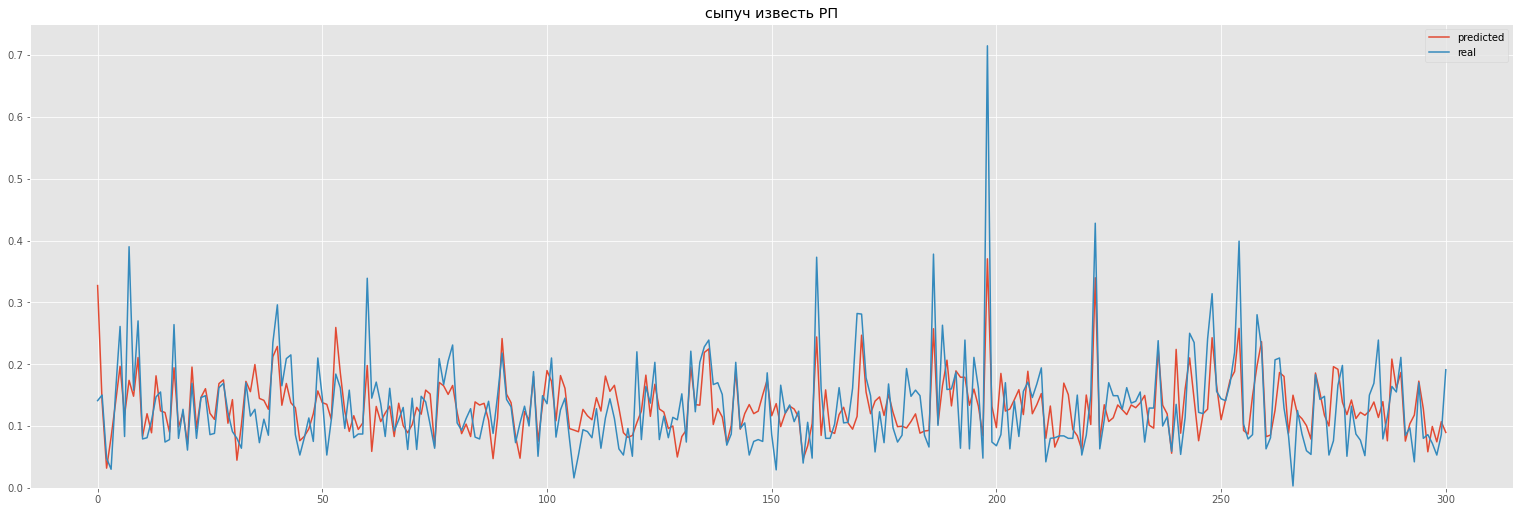

In [10]:
cross_val_universal(df, LinearRegression(), target, display_text=True)

# Кластеризация

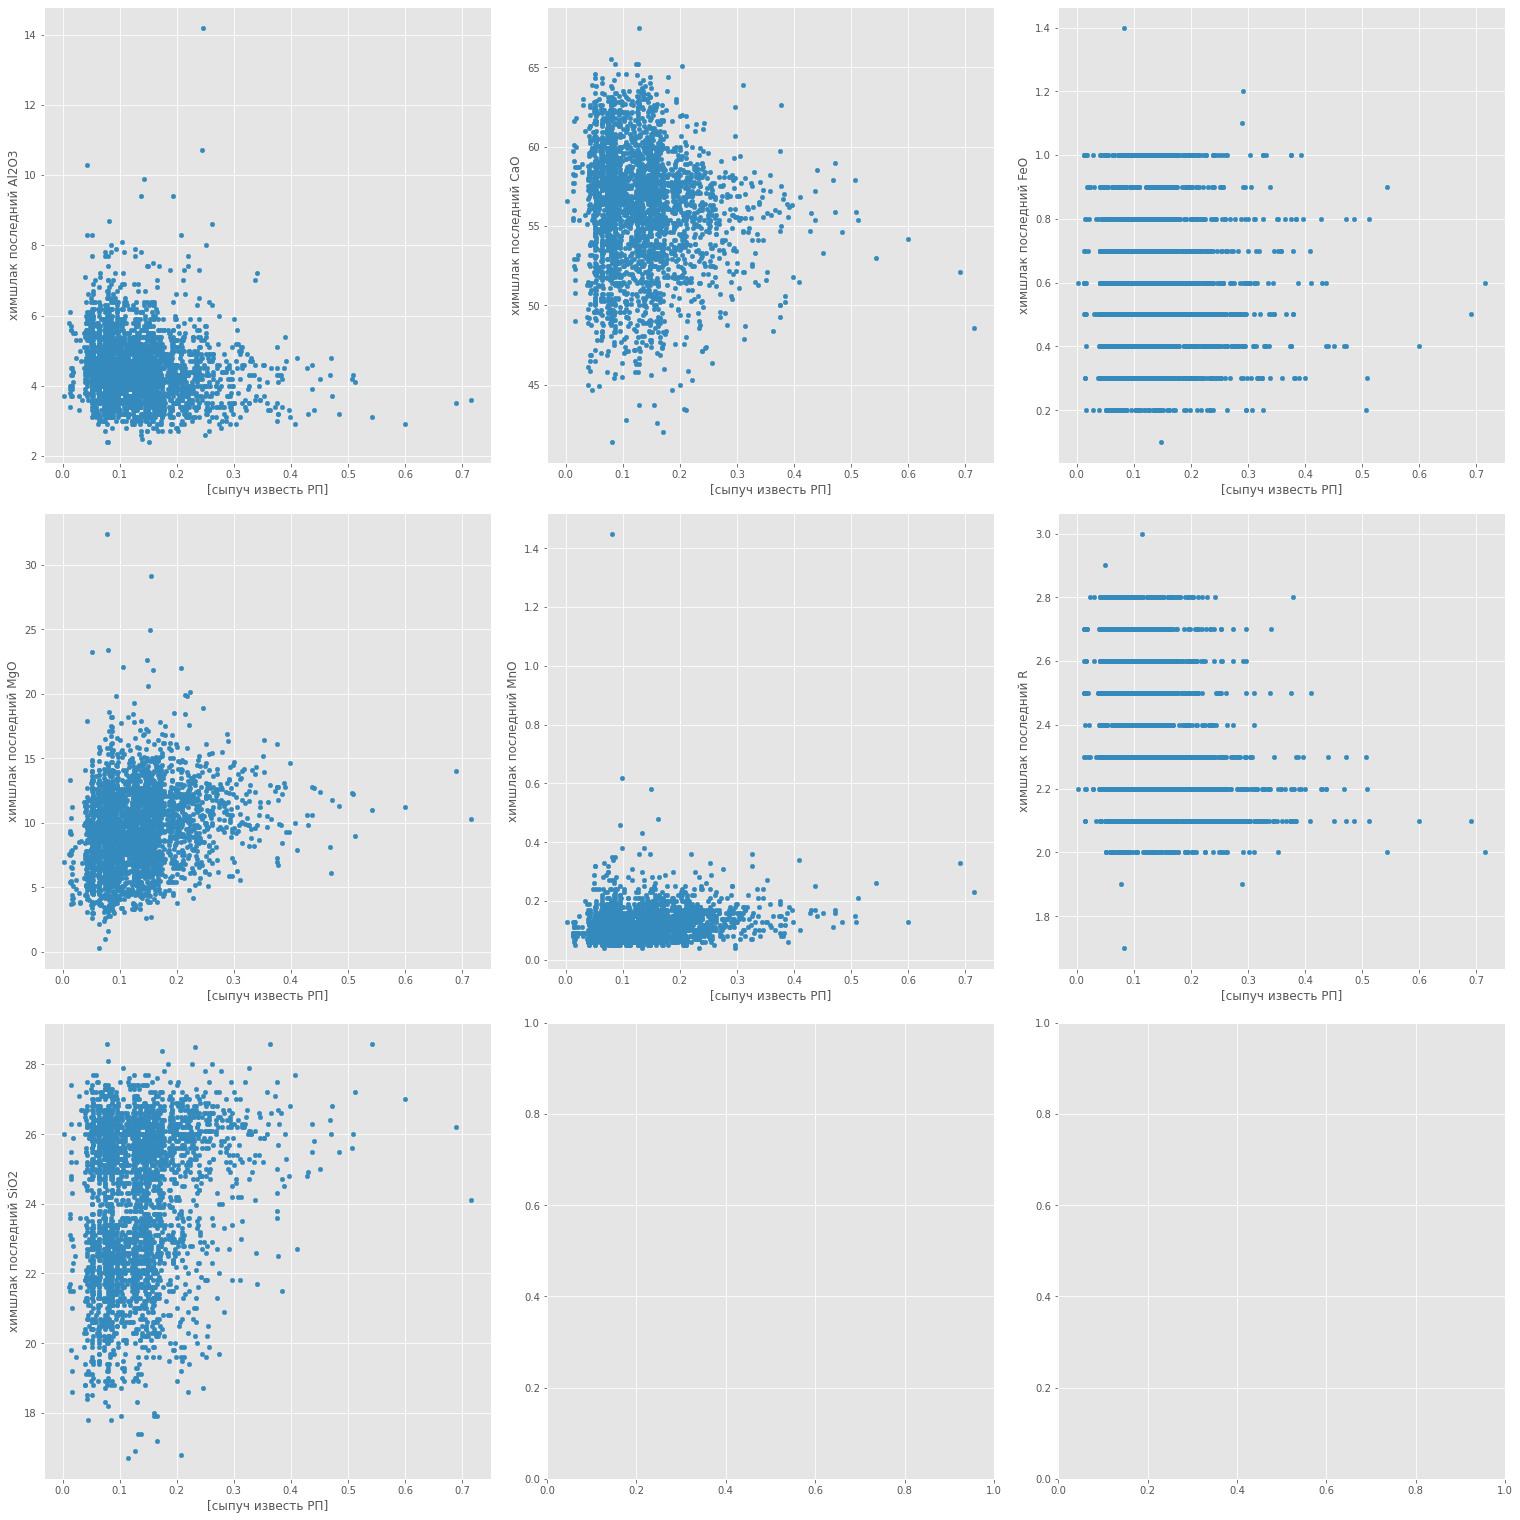

In [11]:
ncols=3
nrows = np.ceil(len(features) / ncols).astype(int)
fig, axes = plt.subplots(ncols=ncols, nrows = nrows, figsize=(7*ncols, 7*nrows), constrained_layout=True)
axes = axes.flatten()

for ax, feature in zip(axes, features):
    df.plot(kind='scatter', x=target, y=feature, ax=ax)